## Análisis de contagios identificados por COVID-19 en Colombia

Fuente: Gobierno Nacional (datos disponibles en este [enlace](https://coronaviruscolombia.gov.co/Covid19/index.html)).
Por favor tener presente:
> Las cifras de contagios en los reportes oficiales **NO refleja la totalidad de contagios** en la población colombiana sino a una fracción menor, correspondiente a los **casos diagnosticados como positivos** en las pruebas de detección realizadas hasta la fecha.

 - La totalidad de personas contagiadas es considerablemente mayor, no solo debido a que personas asintomaticas no se presentaran a una toma de prueba, sino también a un defecto en la maquina para realizar las pruebas desde el 26/03 [leer acá](https://www.eltiempo.com/unidad-investigativa/baja-en-pruebas-de-covid-19-fue-por-falla-que-ya-estan-subsanando-477836)
 - Errores del ajuste pueden estimarse usando la matrix de covariancia **pcov**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
confirmed_cases = pd.read_csv("casos_03_30.csv")
confirmed_cases

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención**,Edad,Sexo,Tipo*,País de procedencia
0,1,06/03/2020,Bogotá,Bogotá,Recuperado,10 a 19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,30 a 39,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50 a 59,F,Importado,España
3,4,11/03/2020,Medellín,Antioquia,En casa,50 a 59,M,Relacionado,Colombia
4,5,11/03/2020,Medellín,Antioquia,Recuperado,20 a 29,M,Relacionado,Colombia
...,...,...,...,...,...,...,...,...,...
793,794,30/3/2020,Palmira,Valle del Cauca,En casa,50 a 59,F,Importado,España
794,795,30/3/2020,Palmira,Valle del Cauca,En casa,10 a 19,M,Relacionado,Colombia
795,796,30/3/2020,Palmira,Valle del Cauca,En casa,20 a 29,M,Importado,España
796,797,30/3/2020,Cali,Valle del Cauca,Hospital,80 a 89,M,En estudio,Colombia


In [3]:
# dataframe processing for analysis
original_names = confirmed_cases.columns.to_list()
column_names = ['id','date','city','state','status','age','gender','origin','related_origin_country']
column_types = ['int','str','str','str','str','str','str','str','str']

df = ( confirmed_cases.copy()
      .astype(  dtype={k:v for k,v in zip(original_names, column_types)})
      .rename(columns={k:v for k,v in zip(original_names, column_names)})
     ).set_index('id')
df['date'] = pd.to_datetime(df['date'],dayfirst=True)

# Evolución de casos por departamento

In [4]:
gb_state = df.groupby(['state','date'])
df_state = gb_state.apply(len).reset_index().rename(columns={0:'new_daily'})
df_state['cum_sum'] = np.nan
for state in df_state.state.unique():
    mask = df_state.state == state
    df_state.cum_sum[mask] = df_state.new_daily[mask].cumsum()

d:\python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


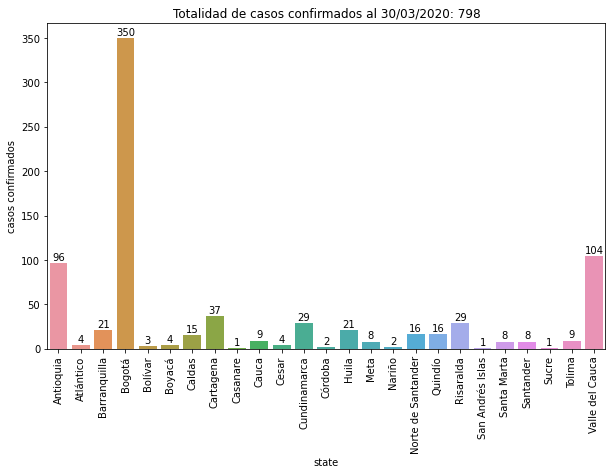

In [5]:
plt.figure(figsize=(10,6))
ss = df_state.groupby(['state']).cum_sum.max().reset_index()

sns.barplot(x='state',y='cum_sum',data=ss)
for i in ss.index:
    plt.gca().text(i , ss.loc[i,'cum_sum'] +1, str(int(ss.loc[i,'cum_sum'])),
            ha='center', va='bottom')  
plt.title(f"Totalidad de casos confirmados al {df.date.max().strftime('%d/%m/%Y')}: {int(ss.cum_sum.sum())}")
plt.ylabel('casos confirmados')
plt.xticks(rotation=90)
plt.savefig('casos_por_departamentos.png')

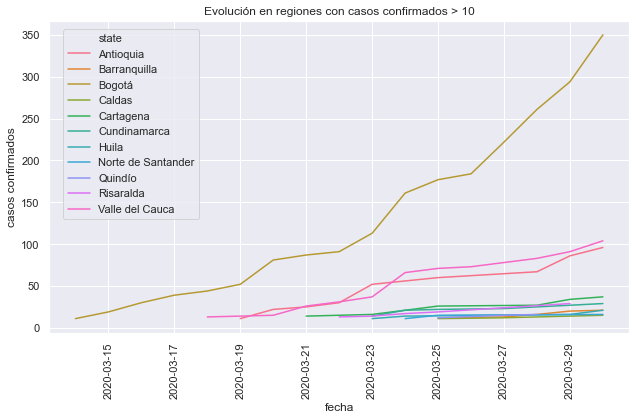

In [6]:
plt.figure(figsize=(9,6))
sns.set()
sns.lineplot(x="date", y="cum_sum",
             hue="state",
             data=df_state[df_state.cum_sum>10])
box = plt.gca().get_position()
#plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.gca().legend(loc='upper left', bbox_to_anchor=(0.015, 0.99))
plt.xticks(rotation=90)
plt.xlabel('fecha')
plt.ylabel('casos confirmados')
plt.title('Evolución en regiones con casos confirmados > 10')
plt.tight_layout()
plt.savefig('evolucion_por_departamentos.png')


###  Evolución de casos confirmados a nivel nacional y prognostico dos días siguientes

In [7]:
df_daily = ( df.groupby(['date'])
            .apply(len)
            .reset_index()
            .rename(columns={0:'new_daily'})
           )
df_daily['cum_sum'] = pd.Series([df_daily['new_daily'].iloc[:i+1].sum() for i in df_daily.index])

In [8]:
def exp_func(x, a, b, c):
    return a*np.exp(b*x)+c

mask = df_daily.cum_sum >= 40
x=df_daily[mask].index
y=df_daily[mask].cum_sum

popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1e-6, 1))

xx=np.append(np.array(x),np.array([x.max()+1,x.max()+2]))
yy=exp_func(xx, *popt)

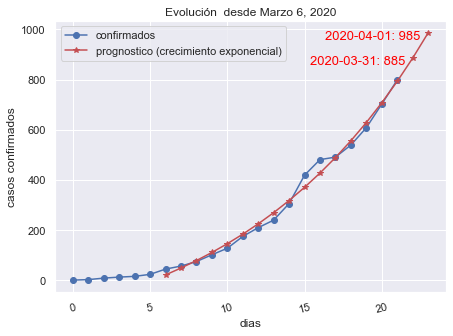

In [11]:
f2 = plt.figure(figsize=(7,5))
plt.plot(df_daily.index, df_daily.cum_sum, 'o-',label='confirmados')
for i in [1,2]:
    date = (df.date.max() +dt.timedelta(days=i)).strftime('%Y-%m-%d')
    plt.text(xx[-3+i]-0.5, yy[-3+i]+10, f'{date}: {int(yy[-3+i])}', {'color': 'red', 'fontsize': 13}, va="top", ha="right")
plt.plot(xx, yy, '*-',c='r',label='prognostico (crecimiento exponencial)')

plt.xticks(rotation=15)
plt.xlabel('dias')
plt.ylabel('casos confirmados')
plt.title('Evolución  desde Marzo 6, 2020')
plt.grid(True)
plt.legend()
plt.savefig('evolucion.png')
plt.show()

### growth rate

In [10]:
### benchmarks growths

# 33% of daily growth:
# N(t+1)/N(t) = 1.33 = (a*np.exp(b*(x+1))+c)/(a*np.exp(b*x)+c) ==> 1.33(a+c)=a*np.exp(b)-c
#                     = np.exp(-b)   
#          log(a)*b = np.log(1.33)

#x_ex = df_daily.index
#b = np.log(1.33)
#yy_33=exp_func(x_ex, 1,b)

# 50% daily growth
#b = np.log(1.4)
#yy_50=exp_func(x_ex, 1,b)

#plt.plot(x_ex, yy_33, '*--',c='black',label='crecimiento 33% diario')
#plt.plot(x_ex, yy_50, '*--',c='black',label='crecimiento 50% diario')

### análisis número de pruebas procesadas

fuente: twitter instituto nacional de salud [acá](https://twitter.com/INSColombia/status/1244140766626267136/photo/1)

In [19]:
n_daily_tests = [42,32,71,41,125,188,310,319,343,209,330,443,585,645,558,591,1040,1004,988,364,1073,1413]
dates = [df.date.min() +dt.timedelta(days=i) for i in range(0,len(n_daily_tests))]
df_daily_tests = pd.DataFrame(data={'date':dates,'n_daily_tests':n_daily_tests})
df_daily_tests

,date,n_daily_tests
0,2020-03-06,42
1,2020-03-07,32
2,2020-03-08,71
3,2020-03-09,41
4,2020-03-10,125
5,2020-03-11,188
6,2020-03-12,310
7,2020-03-13,319
8,2020-03-14,343
9,2020-03-15,209
